### Firstly, we set up our data and install necessary packages


In [ ]:
!pip install -U gdown
import gdown

file_id = "17dJko5mDYFbCNYRBWLSTKxLp6FihKje5"
url = f"https://drive.google.com/uc?id={file_id}"
output = "splits.zip"

gdown.download(url, output, quiet=False)

!unzip -q splits.zip -d /content/

Downloading...
From (original): https://drive.google.com/uc?id=17dJko5mDYFbCNYRBWLSTKxLp6FihKje5
From (redirected): https://drive.google.com/uc?id=17dJko5mDYFbCNYRBWLSTKxLp6FihKje5&confirm=t&uuid=15440689-bfce-4b07-924d-6471a85e9929
To: /content/splits.zip
100%|██████████| 1.73G/1.73G [00:41<00:00, 41.1MB/s]


In [ ]:
!pip install timm torchvision pandas transformers
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
import json
import ast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

### We set up the seed for reproducibility

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

### We use two pretrained models. One is a basic ViT-B16 transformer and the second one is a smaller ViT-S16 transformer. We also test different learning rates. To distinguish between these two, the first one has default depths length set to 12, and the second - to 8. We do not change these, we just keep this to track which model is being trained.

In [ ]:
DATA_ROOT = 'splits/split_10'
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TESTING HYPERPARAMETERS
DEPTHS = [12, 8]
LRS = [1e-5, 3e-5, 1e-4, 3e-4]

In [ ]:
def create_dataloaders():
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # ViT expects 3 channels
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_data = datasets.ImageFolder(
        os.path.join(DATA_ROOT, 'train'),
        transform=transform
    )
    val_data = datasets.ImageFolder(
        os.path.join(DATA_ROOT, 'val'),
        transform=transform
    )
    test_data = datasets.ImageFolder(
        os.path.join(DATA_ROOT, 'test'),
        transform=transform
    )

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    return train_loader, val_loader, test_loader, train_data.classes

In [ ]:
def create_model(depth):
    model_name = f'vit_base_patch16_224'
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=10,
        depth=depth
    )
    return model.to(DEVICE)

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs):
    results = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation
        val_loss, val_correct = validate_model(model, val_loader, criterion)
        val_acc = val_correct / len(val_loader.dataset)

        # Store results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    return results

In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    return val_loss/len(val_loader), val_correct

In [ ]:
def test_model(model, test_loader, classes):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    test_acc = 100 * sum(1 for x,y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    f1_per_class = f1_score(all_labels, all_preds, average=None) * 100
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'accuracy': test_acc,
        'f1_score': f1,
        'f1_per_class': f1_per_class.tolist(),
        'class_names': classes,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }

In [ ]:
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def plot_training_curves(results, depth, lr):
    epochs = list(range(1, len(results['train_loss'])+1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, results['train_loss'], label='Train')
    plt.plot(epochs, results['val_loss'], label='Validation')
    plt.title(f'Loss Curve for depth={depth}, lr={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in results['train_acc']], label='Train')
    plt.plot(epochs, [acc * 100 for acc in results['val_acc']], label='Validation')
    plt.title(f'Accuracy Curve for depth={depth}, lr={lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
all_results = {}

### The main loop is here. We use a scheduler for learning rate parameter. The first 10% steps utilize linear warmup, then it gradually decreases with cosine decay.  

In [ ]:
def main_loop(depth, lr):
    print(f"\n=== Training with depth={depth}, lr={lr} ===")

    # Initialize
    train_loader, val_loader, test_loader, classes = create_dataloaders()
    model = create_model(depth)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Scheduler
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1*total_steps),
        num_training_steps=total_steps
    )

    # Training
    results = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, EPOCHS)

    # Testing
    test_metrics = test_model(model, test_loader, classes)
    results['test_metrics'] = test_metrics

    # Save results
    key = f'depth{depth}_lr{lr}'
    all_results[key] = results
    torch.save(model.state_dict(), f'{key}_model.pth')

    flat_metrics = {
        'depth': depth,
        'lr': lr,
        'train_losses': str(results['train_loss']),
        'val_losses': str(results['val_loss']),
        'train_accuracies': str(results['train_acc']),
        'val_accuracies': str(results['val_acc']),
        'test_accuracy': test_metrics['accuracy'],
        'test_f1_score': test_metrics['f1_score'],
    }

    df = pd.DataFrame([flat_metrics])
    csv_file = 'training_history_flattened.csv'
    if os.path.exists(csv_file):
        existing_df = pd.read_csv(csv_file)
        df = pd.concat([existing_df, df], ignore_index=True)
    df.to_csv(csv_file, index=False)

    # Plotting
    plot_training_curves(results, depth, lr)
    print('========')
    plot_confusion_matrix(test_metrics['confusion_matrix'], classes, f'Confusion Matrix (depth={depth}, lr={lr})')

    # Print metrics
    print(f"\nTest Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"F1 Score: {test_metrics['f1_score']:.2f}%")
    print("\nPer-class F1 Scores:")
    for name, score in zip(test_metrics['class_names'], test_metrics['f1_per_class']):
        print(f"  {name}: {score:.2f}%")

### Training takes a lot of time, even on Google Colab, so we do each step by step. First the regular ViT-B16 transformer.


=== Training with depth=12, lr=1e-05 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 518/518 [10:03<00:00,  1.16s/it]


[Epoch 1] Train Loss: 1.3319 | Train Acc: 53.91% | Val Loss: 0.5243 | Val Acc: 82.00%


Epoch 2/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 2] Train Loss: 0.3210 | Train Acc: 89.03% | Val Loss: 0.2794 | Val Acc: 90.89%


Epoch 3/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 3] Train Loss: 0.1660 | Train Acc: 94.32% | Val Loss: 0.2413 | Val Acc: 91.82%


Epoch 4/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 4] Train Loss: 0.0916 | Train Acc: 96.77% | Val Loss: 0.2345 | Val Acc: 93.55%


Epoch 5/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 5] Train Loss: 0.0617 | Train Acc: 97.92% | Val Loss: 0.2264 | Val Acc: 94.31%


Epoch 6/20: 100%|██████████| 518/518 [09:56<00:00,  1.15s/it]


[Epoch 6] Train Loss: 0.0451 | Train Acc: 98.59% | Val Loss: 0.2100 | Val Acc: 94.69%


Epoch 7/20: 100%|██████████| 518/518 [09:59<00:00,  1.16s/it]


[Epoch 7] Train Loss: 0.0239 | Train Acc: 99.23% | Val Loss: 0.2473 | Val Acc: 93.97%


Epoch 8/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 8] Train Loss: 0.0097 | Train Acc: 99.79% | Val Loss: 0.2478 | Val Acc: 94.14%


Epoch 9/20: 100%|██████████| 518/518 [09:59<00:00,  1.16s/it]


[Epoch 9] Train Loss: 0.0058 | Train Acc: 99.81% | Val Loss: 0.2445 | Val Acc: 94.56%


Epoch 10/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 10] Train Loss: 0.0213 | Train Acc: 99.31% | Val Loss: 0.2423 | Val Acc: 95.15%


Epoch 11/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 11] Train Loss: 0.0037 | Train Acc: 99.91% | Val Loss: 0.2438 | Val Acc: 95.36%


Epoch 12/20: 100%|██████████| 518/518 [09:56<00:00,  1.15s/it]


[Epoch 12] Train Loss: 0.0006 | Train Acc: 100.00% | Val Loss: 0.2580 | Val Acc: 95.28%


Epoch 13/20: 100%|██████████| 518/518 [09:56<00:00,  1.15s/it]


[Epoch 13] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2402 | Val Acc: 95.62%


Epoch 14/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 14] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2411 | Val Acc: 95.70%


Epoch 15/20: 100%|██████████| 518/518 [09:59<00:00,  1.16s/it]


[Epoch 15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2418 | Val Acc: 95.66%


Epoch 16/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 16] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2421 | Val Acc: 95.66%


Epoch 17/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 17] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2424 | Val Acc: 95.62%


Epoch 18/20: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]


[Epoch 18] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2426 | Val Acc: 95.62%


Epoch 19/20: 100%|██████████| 518/518 [09:56<00:00,  1.15s/it]


[Epoch 19] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2426 | Val Acc: 95.66%


Epoch 20/20: 100%|██████████| 518/518 [09:58<00:00,  1.16s/it]


[Epoch 20] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2426 | Val Acc: 95.66%


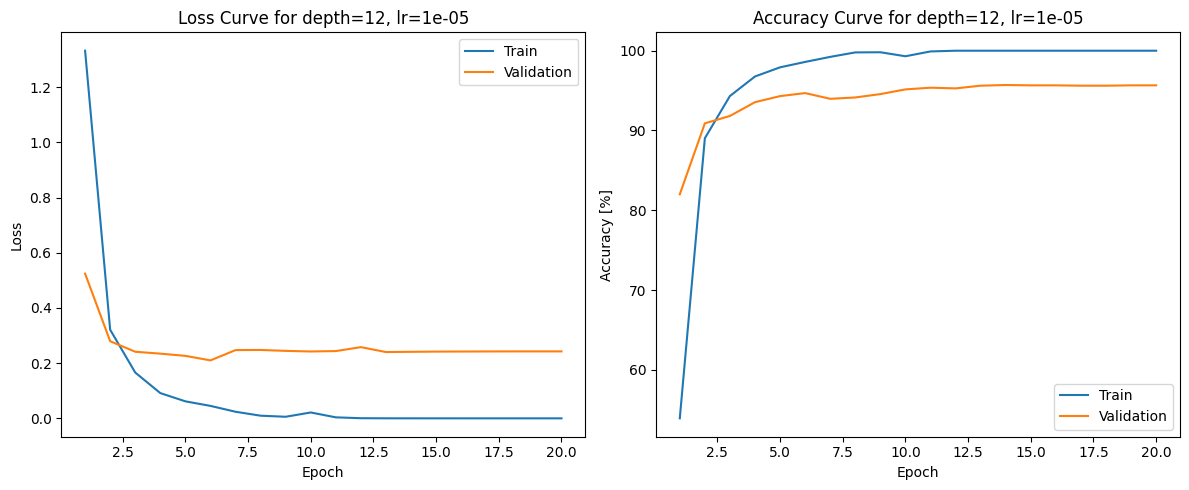

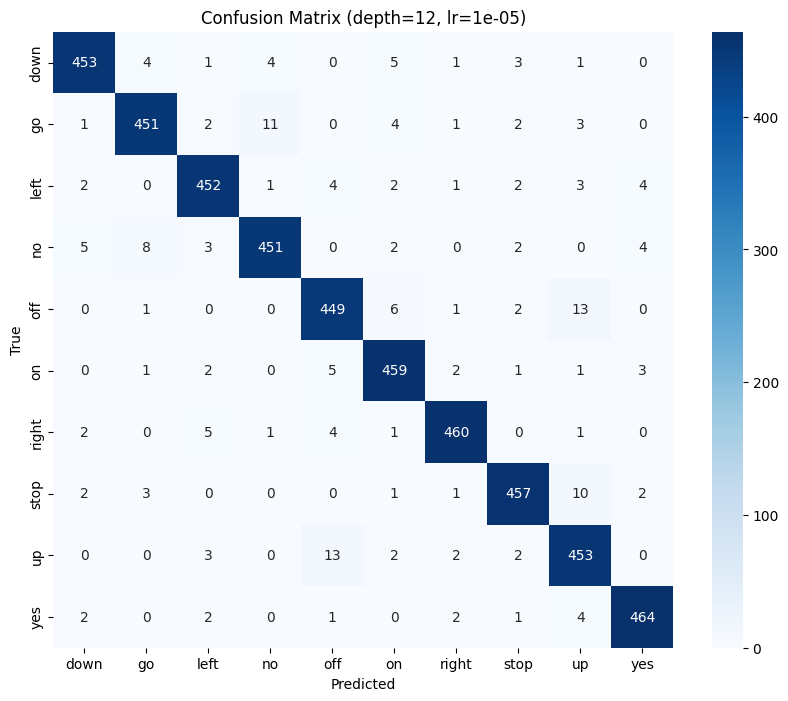


Test Accuracy: 95.97%
F1 Score: 95.97%

Per-class F1 Scores:
  down: 96.49%
  go: 95.65%
  left: 96.07%
  no: 95.65%
  off: 94.73%
  on: 96.03%
  right: 97.35%
  stop: 96.41%
  up: 93.98%
  yes: 97.38%


In [ ]:
main_loop(DEPTHS[0], LRS[0])


=== Training with depth=12, lr=3e-05 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 518/518 [09:47<00:00,  1.13s/it]


[Epoch 1] Train Loss: 0.9945 | Train Acc: 65.43% | Val Loss: 0.4987 | Val Acc: 83.73%


Epoch 2/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 2] Train Loss: 0.2504 | Train Acc: 91.61% | Val Loss: 0.2879 | Val Acc: 91.06%


Epoch 3/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 3] Train Loss: 0.1489 | Train Acc: 94.86% | Val Loss: 0.2520 | Val Acc: 91.57%


Epoch 4/20: 100%|██████████| 518/518 [09:39<00:00,  1.12s/it]


[Epoch 4] Train Loss: 0.0967 | Train Acc: 96.69% | Val Loss: 0.1778 | Val Acc: 94.73%


Epoch 5/20: 100%|██████████| 518/518 [09:39<00:00,  1.12s/it]


[Epoch 5] Train Loss: 0.0749 | Train Acc: 97.47% | Val Loss: 0.2217 | Val Acc: 94.14%


Epoch 6/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 6] Train Loss: 0.0547 | Train Acc: 98.20% | Val Loss: 0.2160 | Val Acc: 94.31%


Epoch 7/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 7] Train Loss: 0.0457 | Train Acc: 98.52% | Val Loss: 0.2065 | Val Acc: 95.19%


Epoch 8/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 8] Train Loss: 0.0278 | Train Acc: 99.12% | Val Loss: 0.2508 | Val Acc: 94.52%


Epoch 9/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 9] Train Loss: 0.0255 | Train Acc: 99.20% | Val Loss: 0.1948 | Val Acc: 95.83%


Epoch 10/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 10] Train Loss: 0.0118 | Train Acc: 99.61% | Val Loss: 0.2796 | Val Acc: 94.60%


Epoch 11/20: 100%|██████████| 518/518 [09:37<00:00,  1.12s/it]


[Epoch 11] Train Loss: 0.0154 | Train Acc: 99.51% | Val Loss: 0.2149 | Val Acc: 95.78%


Epoch 12/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 12] Train Loss: 0.0046 | Train Acc: 99.86% | Val Loss: 0.2042 | Val Acc: 96.25%


Epoch 13/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 13] Train Loss: 0.0018 | Train Acc: 99.97% | Val Loss: 0.2159 | Val Acc: 96.25%


Epoch 14/20: 100%|██████████| 518/518 [09:39<00:00,  1.12s/it]


[Epoch 14] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2122 | Val Acc: 96.46%


Epoch 15/20: 100%|██████████| 518/518 [09:39<00:00,  1.12s/it]


[Epoch 15] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2148 | Val Acc: 96.42%


Epoch 16/20: 100%|██████████| 518/518 [09:39<00:00,  1.12s/it]


[Epoch 16] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2165 | Val Acc: 96.46%


Epoch 17/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 17] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2177 | Val Acc: 96.50%


Epoch 18/20: 100%|██████████| 518/518 [09:39<00:00,  1.12s/it]


[Epoch 18] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2183 | Val Acc: 96.50%


Epoch 19/20: 100%|██████████| 518/518 [09:37<00:00,  1.12s/it]


[Epoch 19] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2186 | Val Acc: 96.50%


Epoch 20/20: 100%|██████████| 518/518 [09:37<00:00,  1.12s/it]


[Epoch 20] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2187 | Val Acc: 96.50%


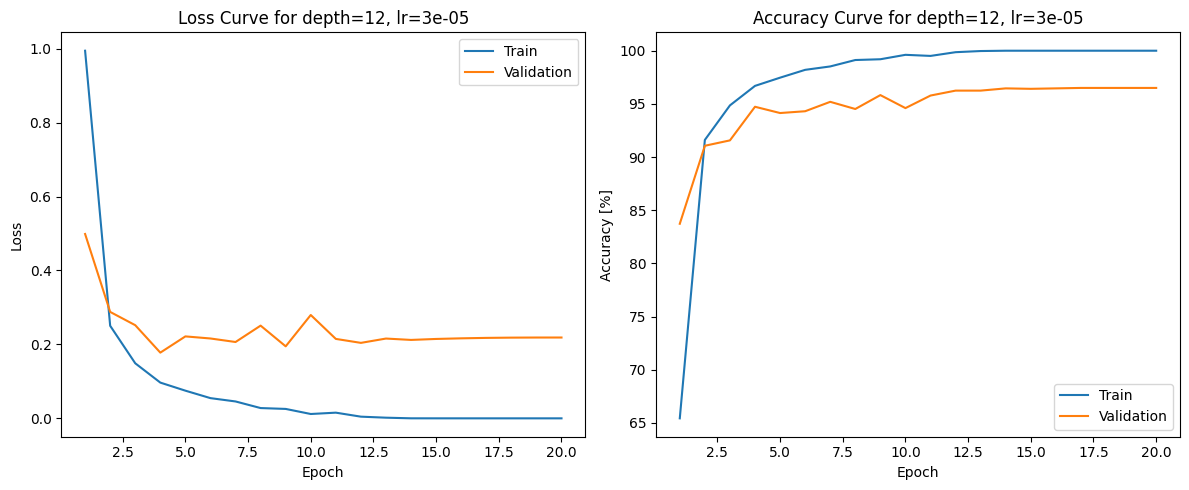

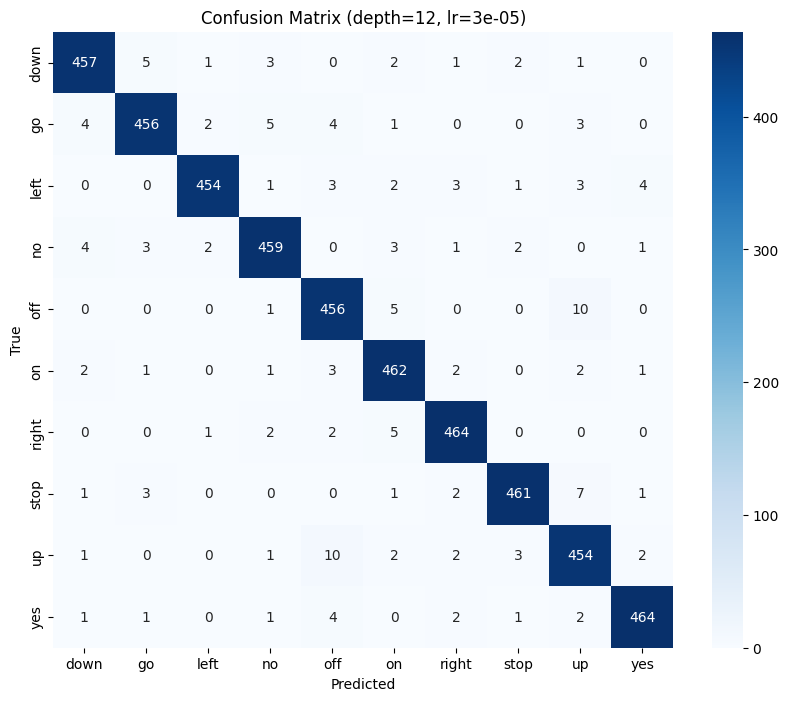


Test Accuracy: 96.77%
F1 Score: 96.78%

Per-class F1 Scores:
  down: 97.03%
  go: 96.61%
  left: 97.53%
  no: 96.73%
  off: 95.60%
  on: 96.55%
  right: 97.58%
  stop: 97.46%
  up: 94.88%
  yes: 97.79%


In [ ]:
main_loop(DEPTHS[0], LRS[1])


=== Training with depth=12, lr=0.0001 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]


[Epoch 1] Train Loss: 0.7660 | Train Acc: 73.34% | Val Loss: 0.3059 | Val Acc: 90.26%


Epoch 2/20: 100%|██████████| 518/518 [09:29<00:00,  1.10s/it]


[Epoch 2] Train Loss: 0.2353 | Train Acc: 92.05% | Val Loss: 0.2392 | Val Acc: 92.33%


Epoch 3/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 3] Train Loss: 0.1724 | Train Acc: 94.21% | Val Loss: 0.1723 | Val Acc: 94.65%


Epoch 4/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 4] Train Loss: 0.1231 | Train Acc: 95.95% | Val Loss: 0.2562 | Val Acc: 92.28%


Epoch 5/20: 100%|██████████| 518/518 [09:29<00:00,  1.10s/it]


[Epoch 5] Train Loss: 0.1074 | Train Acc: 96.29% | Val Loss: 0.1930 | Val Acc: 94.52%


Epoch 6/20: 100%|██████████| 518/518 [09:29<00:00,  1.10s/it]


[Epoch 6] Train Loss: 0.0898 | Train Acc: 96.95% | Val Loss: 0.1870 | Val Acc: 95.19%


Epoch 7/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 7] Train Loss: 0.0811 | Train Acc: 97.31% | Val Loss: 0.1571 | Val Acc: 95.07%


Epoch 8/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 8] Train Loss: 0.0677 | Train Acc: 97.65% | Val Loss: 0.2279 | Val Acc: 93.42%


Epoch 9/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 9] Train Loss: 0.0630 | Train Acc: 97.88% | Val Loss: 0.1812 | Val Acc: 94.69%


Epoch 10/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 10] Train Loss: 0.0424 | Train Acc: 98.58% | Val Loss: 0.2109 | Val Acc: 94.73%


Epoch 11/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 11] Train Loss: 0.0303 | Train Acc: 98.96% | Val Loss: 0.2445 | Val Acc: 94.56%


Epoch 12/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 12] Train Loss: 0.0246 | Train Acc: 99.22% | Val Loss: 0.1806 | Val Acc: 96.29%


Epoch 13/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 13] Train Loss: 0.0181 | Train Acc: 99.38% | Val Loss: 0.1735 | Val Acc: 96.50%


Epoch 14/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 14] Train Loss: 0.0026 | Train Acc: 99.92% | Val Loss: 0.1803 | Val Acc: 96.59%


Epoch 15/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 15] Train Loss: 0.0008 | Train Acc: 99.98% | Val Loss: 0.1960 | Val Acc: 96.63%


Epoch 16/20: 100%|██████████| 518/518 [09:29<00:00,  1.10s/it]


[Epoch 16] Train Loss: 0.0003 | Train Acc: 99.99% | Val Loss: 0.2029 | Val Acc: 96.92%


Epoch 17/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 17] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2078 | Val Acc: 96.84%


Epoch 18/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 18] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2102 | Val Acc: 96.84%


Epoch 19/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 19] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2112 | Val Acc: 96.84%


Epoch 20/20: 100%|██████████| 518/518 [09:28<00:00,  1.10s/it]


[Epoch 20] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2113 | Val Acc: 96.84%


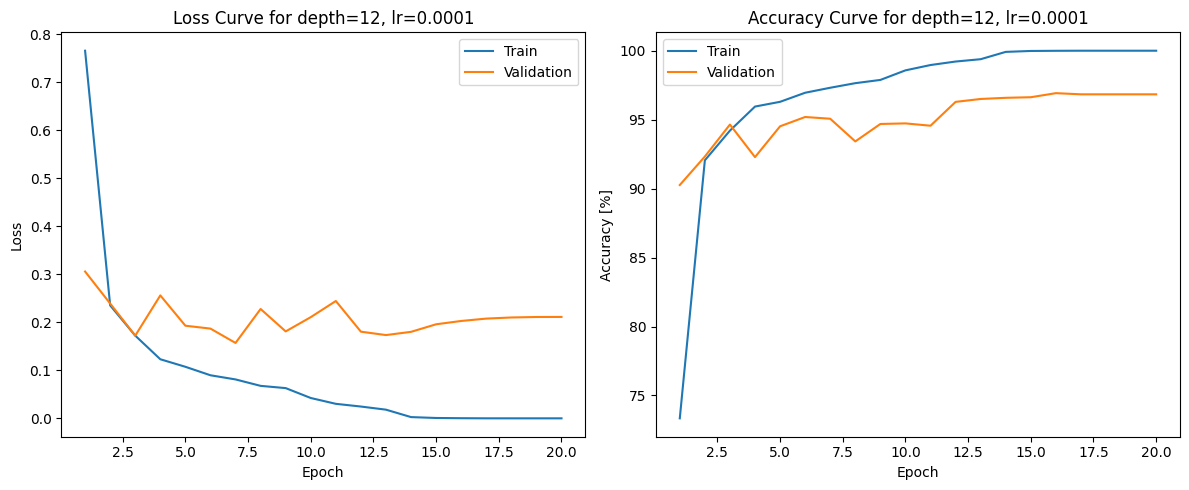

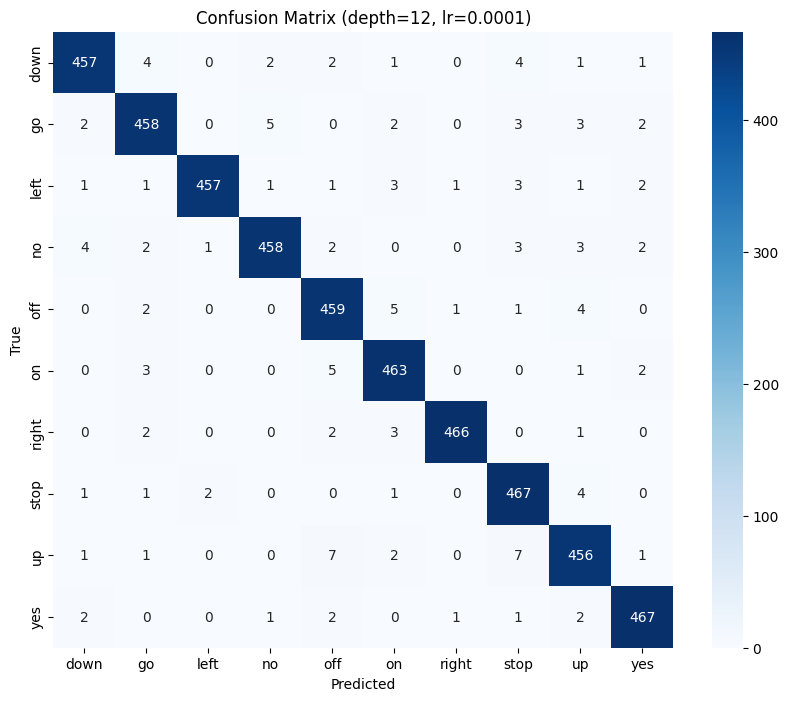


Test Accuracy: 97.22%
F1 Score: 97.22%

Per-class F1 Scores:
  down: 97.23%
  go: 96.52%
  left: 98.17%
  no: 97.24%
  off: 96.43%
  on: 97.06%
  right: 98.83%
  stop: 96.79%
  up: 95.90%
  yes: 98.01%


In [ ]:
main_loop(DEPTHS[0], LRS[2])


=== Training with depth=12, lr=0.0003 ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 518/518 [09:24<00:00,  1.09s/it]


[Epoch 1] Train Loss: 0.6705 | Train Acc: 77.04% | Val Loss: 0.2800 | Val Acc: 90.85%


Epoch 2/20: 100%|██████████| 518/518 [09:13<00:00,  1.07s/it]


[Epoch 2] Train Loss: 0.3031 | Train Acc: 90.13% | Val Loss: 0.2948 | Val Acc: 89.97%


Epoch 3/20: 100%|██████████| 518/518 [09:13<00:00,  1.07s/it]


[Epoch 3] Train Loss: 0.2499 | Train Acc: 91.67% | Val Loss: 0.2890 | Val Acc: 90.68%


Epoch 4/20: 100%|██████████| 518/518 [09:11<00:00,  1.07s/it]


[Epoch 4] Train Loss: 0.2151 | Train Acc: 93.15% | Val Loss: 0.2608 | Val Acc: 91.99%


Epoch 5/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 5] Train Loss: 0.2119 | Train Acc: 92.75% | Val Loss: 0.3744 | Val Acc: 87.82%


Epoch 6/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 6] Train Loss: 0.1801 | Train Acc: 93.92% | Val Loss: 0.2960 | Val Acc: 90.43%


Epoch 7/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 7] Train Loss: 0.1658 | Train Acc: 94.52% | Val Loss: 0.1881 | Val Acc: 93.47%


Epoch 8/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 8] Train Loss: 0.1536 | Train Acc: 94.90% | Val Loss: 0.1784 | Val Acc: 94.14%


Epoch 9/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 9] Train Loss: 0.1287 | Train Acc: 95.59% | Val Loss: 0.2006 | Val Acc: 94.10%


Epoch 10/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 10] Train Loss: 0.1053 | Train Acc: 96.42% | Val Loss: 0.1631 | Val Acc: 94.77%


Epoch 11/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 11] Train Loss: 0.0876 | Train Acc: 97.02% | Val Loss: 0.2332 | Val Acc: 92.71%


Epoch 12/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 12] Train Loss: 0.0695 | Train Acc: 97.61% | Val Loss: 0.1657 | Val Acc: 94.77%


Epoch 13/20: 100%|██████████| 518/518 [09:11<00:00,  1.07s/it]


[Epoch 13] Train Loss: 0.0437 | Train Acc: 98.53% | Val Loss: 0.1835 | Val Acc: 95.66%


Epoch 14/20: 100%|██████████| 518/518 [09:13<00:00,  1.07s/it]


[Epoch 14] Train Loss: 0.0290 | Train Acc: 99.11% | Val Loss: 0.2210 | Val Acc: 94.90%


Epoch 15/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 15] Train Loss: 0.0167 | Train Acc: 99.43% | Val Loss: 0.2435 | Val Acc: 94.56%


Epoch 16/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 16] Train Loss: 0.0047 | Train Acc: 99.88% | Val Loss: 0.2224 | Val Acc: 96.25%


Epoch 17/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 17] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.2308 | Val Acc: 96.42%


Epoch 18/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 18] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.2325 | Val Acc: 96.50%


Epoch 19/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 19] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2338 | Val Acc: 96.50%


Epoch 20/20: 100%|██████████| 518/518 [09:12<00:00,  1.07s/it]


[Epoch 20] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.2340 | Val Acc: 96.50%


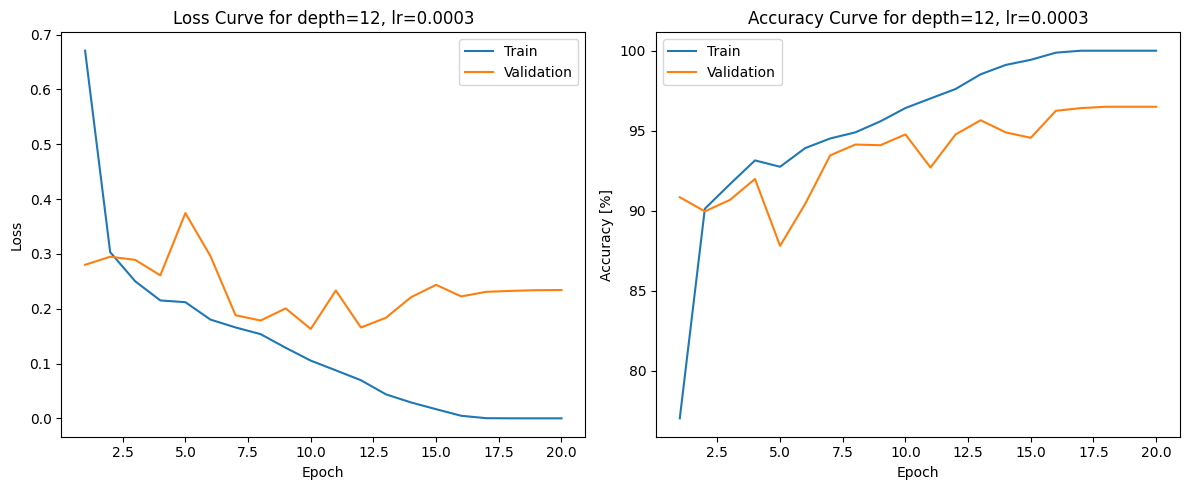

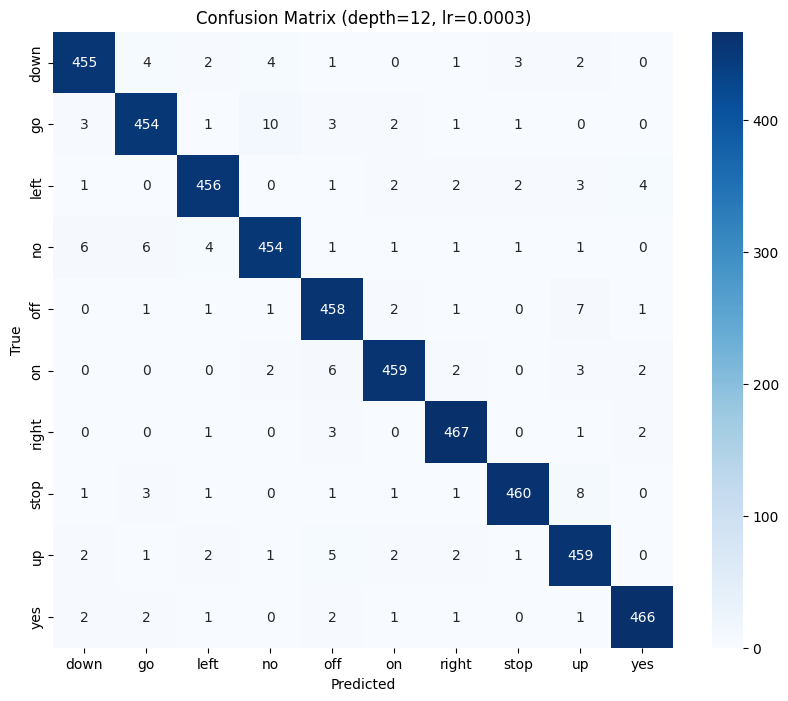


Test Accuracy: 96.79%
F1 Score: 96.79%

Per-class F1 Scores:
  down: 96.60%
  go: 95.98%
  left: 97.02%
  no: 95.88%
  off: 96.12%
  on: 97.25%
  right: 98.01%
  stop: 97.46%
  up: 95.62%
  yes: 98.00%


In [ ]:
main_loop(DEPTHS[0], LRS[3])

### Now the reduced version. We do necessary changes.

In [ ]:
def create_model_small(depth):
    model_name = f'vit_small_patch16_224'
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=10,
        depth=depth
    )
    return model.to(DEVICE)

In [ ]:
def main_loop_small(depth, lr):
    print(f"\n=== Training with depth={depth}, lr={lr} (ViT-S16) ===")

    # Initialize
    train_loader, val_loader, test_loader, classes = create_dataloaders()
    model = create_model_small(depth)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Scheduler
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1*total_steps),
        num_training_steps=total_steps
    )

    # Training
    results = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, EPOCHS)

    # Testing
    test_metrics = test_model(model, test_loader, classes)
    results['test_metrics'] = test_metrics

    # Save results
    key = f'depth{depth}_lr{lr}'
    all_results[key] = results
    torch.save(model.state_dict(), f'{key}_model.pth')

    flat_metrics = {
        'depth': depth,
        'lr': lr,
        'train_losses': str(results['train_loss']),
        'val_losses': str(results['val_loss']),
        'train_accuracies': str(results['train_acc']),
        'val_accuracies': str(results['val_acc']),
        'test_accuracy': test_metrics['accuracy'],
        'test_f1_score': test_metrics['f1_score'],
    }

    df = pd.DataFrame([flat_metrics])
    csv_file = 'training_history_flattened.csv'
    if os.path.exists(csv_file):
        existing_df = pd.read_csv(csv_file)
        df = pd.concat([existing_df, df], ignore_index=True)
    df.to_csv(csv_file, index=False)

    # Plotting
    plot_training_curves(results, depth, lr)
    print('========')
    plot_confusion_matrix(test_metrics['confusion_matrix'], classes, f'Confusion Matrix (depth={depth}, lr={lr})')

    # Print metrics
    print(f"\nTest Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"F1 Score: {test_metrics['f1_score']:.2f}%")
    print("\nPer-class F1 Scores:")
    for name, score in zip(test_metrics['class_names'], test_metrics['f1_per_class']):
        print(f"  {name}: {score:.2f}%")


=== Training with depth=8, lr=1e-05 (ViT-S16) ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 518/518 [02:32<00:00,  3.41it/s]


[Epoch 1] Train Loss: 1.9819 | Train Acc: 31.12% | Val Loss: 1.0104 | Val Acc: 68.21%


Epoch 2/20: 100%|██████████| 518/518 [02:18<00:00,  3.73it/s]


[Epoch 2] Train Loss: 0.5536 | Train Acc: 82.63% | Val Loss: 0.3786 | Val Acc: 88.11%


Epoch 3/20: 100%|██████████| 518/518 [02:19<00:00,  3.70it/s]


[Epoch 3] Train Loss: 0.2653 | Train Acc: 91.68% | Val Loss: 0.2647 | Val Acc: 91.44%


Epoch 4/20: 100%|██████████| 518/518 [02:20<00:00,  3.70it/s]


[Epoch 4] Train Loss: 0.1581 | Train Acc: 95.21% | Val Loss: 0.2771 | Val Acc: 91.02%


Epoch 5/20: 100%|██████████| 518/518 [02:19<00:00,  3.72it/s]


[Epoch 5] Train Loss: 0.1037 | Train Acc: 96.95% | Val Loss: 0.2152 | Val Acc: 93.47%


Epoch 6/20: 100%|██████████| 518/518 [02:19<00:00,  3.71it/s]


[Epoch 6] Train Loss: 0.0644 | Train Acc: 98.24% | Val Loss: 0.2102 | Val Acc: 93.38%


Epoch 7/20: 100%|██████████| 518/518 [02:20<00:00,  3.70it/s]


[Epoch 7] Train Loss: 0.0394 | Train Acc: 99.04% | Val Loss: 0.2203 | Val Acc: 93.47%


Epoch 8/20: 100%|██████████| 518/518 [02:19<00:00,  3.73it/s]


[Epoch 8] Train Loss: 0.0245 | Train Acc: 99.50% | Val Loss: 0.2157 | Val Acc: 93.68%


Epoch 9/20: 100%|██████████| 518/518 [02:19<00:00,  3.70it/s]


[Epoch 9] Train Loss: 0.0142 | Train Acc: 99.81% | Val Loss: 0.2394 | Val Acc: 93.63%


Epoch 10/20: 100%|██████████| 518/518 [02:19<00:00,  3.72it/s]


[Epoch 10] Train Loss: 0.0079 | Train Acc: 99.95% | Val Loss: 0.2330 | Val Acc: 94.06%


Epoch 11/20: 100%|██████████| 518/518 [02:19<00:00,  3.71it/s]


[Epoch 11] Train Loss: 0.0042 | Train Acc: 99.99% | Val Loss: 0.2366 | Val Acc: 93.93%


Epoch 12/20: 100%|██████████| 518/518 [02:19<00:00,  3.70it/s]


[Epoch 12] Train Loss: 0.0027 | Train Acc: 99.99% | Val Loss: 0.2417 | Val Acc: 94.06%


Epoch 13/20: 100%|██████████| 518/518 [02:19<00:00,  3.71it/s]


[Epoch 13] Train Loss: 0.0020 | Train Acc: 100.00% | Val Loss: 0.2407 | Val Acc: 94.27%


Epoch 14/20: 100%|██████████| 518/518 [02:19<00:00,  3.71it/s]


[Epoch 14] Train Loss: 0.0016 | Train Acc: 100.00% | Val Loss: 0.2461 | Val Acc: 94.18%


Epoch 15/20: 100%|██████████| 518/518 [02:18<00:00,  3.73it/s]


[Epoch 15] Train Loss: 0.0013 | Train Acc: 100.00% | Val Loss: 0.2484 | Val Acc: 94.18%


Epoch 16/20: 100%|██████████| 518/518 [02:19<00:00,  3.73it/s]


[Epoch 16] Train Loss: 0.0012 | Train Acc: 100.00% | Val Loss: 0.2491 | Val Acc: 94.18%


Epoch 17/20: 100%|██████████| 518/518 [02:19<00:00,  3.70it/s]


[Epoch 17] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.2517 | Val Acc: 94.10%


Epoch 18/20: 100%|██████████| 518/518 [02:19<00:00,  3.71it/s]


[Epoch 18] Train Loss: 0.0010 | Train Acc: 100.00% | Val Loss: 0.2513 | Val Acc: 94.14%


Epoch 19/20: 100%|██████████| 518/518 [02:19<00:00,  3.71it/s]


[Epoch 19] Train Loss: 0.0009 | Train Acc: 100.00% | Val Loss: 0.2518 | Val Acc: 94.14%


Epoch 20/20: 100%|██████████| 518/518 [02:19<00:00,  3.72it/s]


[Epoch 20] Train Loss: 0.0009 | Train Acc: 100.00% | Val Loss: 0.2521 | Val Acc: 94.14%


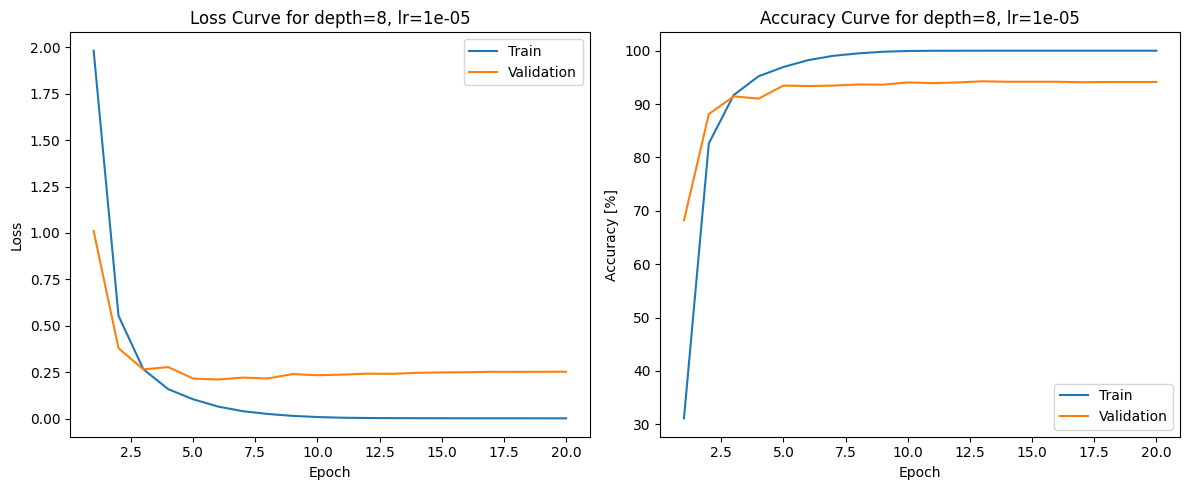

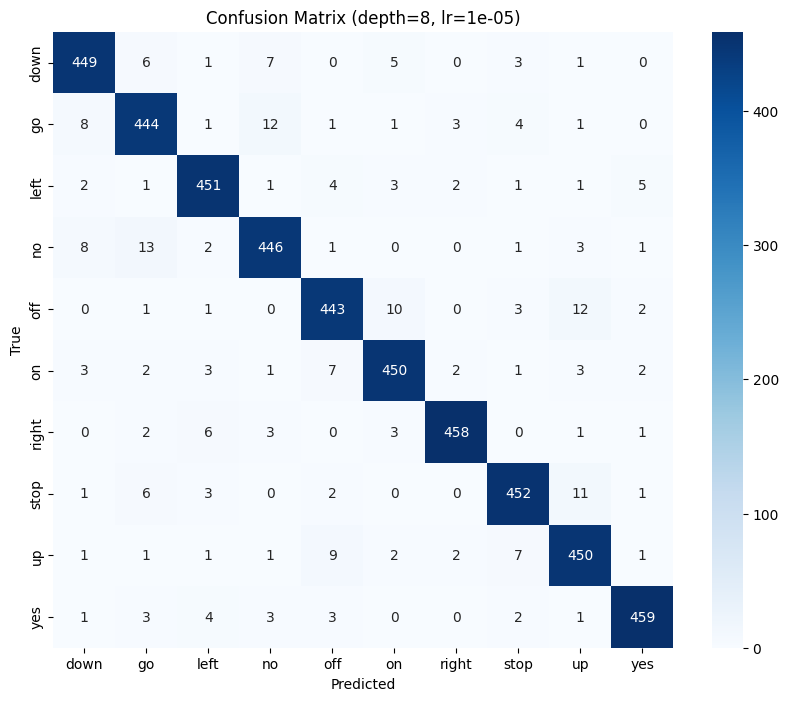


Test Accuracy: 94.98%
F1 Score: 94.98%

Per-class F1 Scores:
  down: 95.03%
  go: 93.08%
  left: 95.55%
  no: 93.99%
  off: 94.06%
  on: 94.94%
  right: 97.34%
  stop: 95.16%
  up: 93.85%
  yes: 96.84%


In [ ]:
main_loop_small(DEPTHS[1], LRS[0])


=== Training with depth=8, lr=3e-05 (ViT-S16) ===


Epoch 1/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 1] Train Loss: 1.4869 | Train Acc: 48.77% | Val Loss: 0.5148 | Val Acc: 83.31%


Epoch 2/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 2] Train Loss: 0.3372 | Train Acc: 89.03% | Val Loss: 0.3121 | Val Acc: 89.92%


Epoch 3/20: 100%|██████████| 518/518 [02:18<00:00,  3.73it/s]


[Epoch 3] Train Loss: 0.1772 | Train Acc: 94.05% | Val Loss: 0.2424 | Val Acc: 92.37%


Epoch 4/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 4] Train Loss: 0.1084 | Train Acc: 96.36% | Val Loss: 0.2271 | Val Acc: 92.96%


Epoch 5/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 5] Train Loss: 0.0616 | Train Acc: 98.09% | Val Loss: 0.1918 | Val Acc: 94.06%


Epoch 6/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 6] Train Loss: 0.0402 | Train Acc: 98.75% | Val Loss: 0.2401 | Val Acc: 93.76%


Epoch 7/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 7] Train Loss: 0.0351 | Train Acc: 98.97% | Val Loss: 0.2314 | Val Acc: 94.48%


Epoch 8/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 8] Train Loss: 0.0163 | Train Acc: 99.55% | Val Loss: 0.2352 | Val Acc: 94.10%


Epoch 9/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 9] Train Loss: 0.0113 | Train Acc: 99.71% | Val Loss: 0.2327 | Val Acc: 94.65%


Epoch 10/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 10] Train Loss: 0.0118 | Train Acc: 99.67% | Val Loss: 0.2252 | Val Acc: 95.36%


Epoch 11/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 11] Train Loss: 0.0008 | Train Acc: 100.00% | Val Loss: 0.2346 | Val Acc: 95.03%


Epoch 12/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 12] Train Loss: 0.0004 | Train Acc: 100.00% | Val Loss: 0.2342 | Val Acc: 95.07%


Epoch 13/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 13] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.2371 | Val Acc: 95.03%


Epoch 14/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 14] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.2378 | Val Acc: 95.11%


Epoch 15/20: 100%|██████████| 518/518 [02:17<00:00,  3.75it/s]


[Epoch 15] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2394 | Val Acc: 95.11%


Epoch 16/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 16] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2404 | Val Acc: 95.11%


Epoch 17/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 17] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2411 | Val Acc: 95.11%


Epoch 18/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 18] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2415 | Val Acc: 95.11%


Epoch 19/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 19] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2416 | Val Acc: 95.11%


Epoch 20/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 20] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.2416 | Val Acc: 95.15%


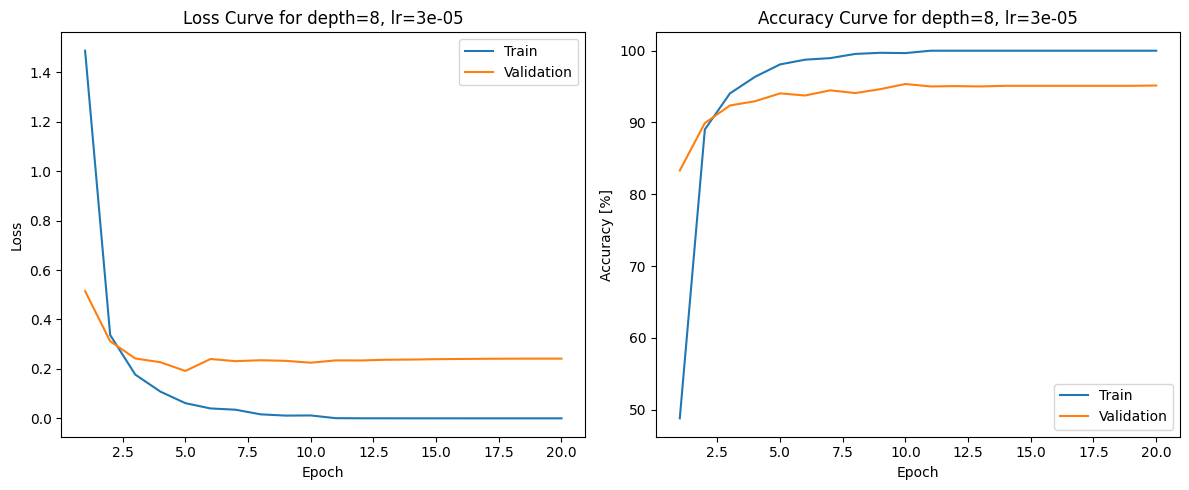

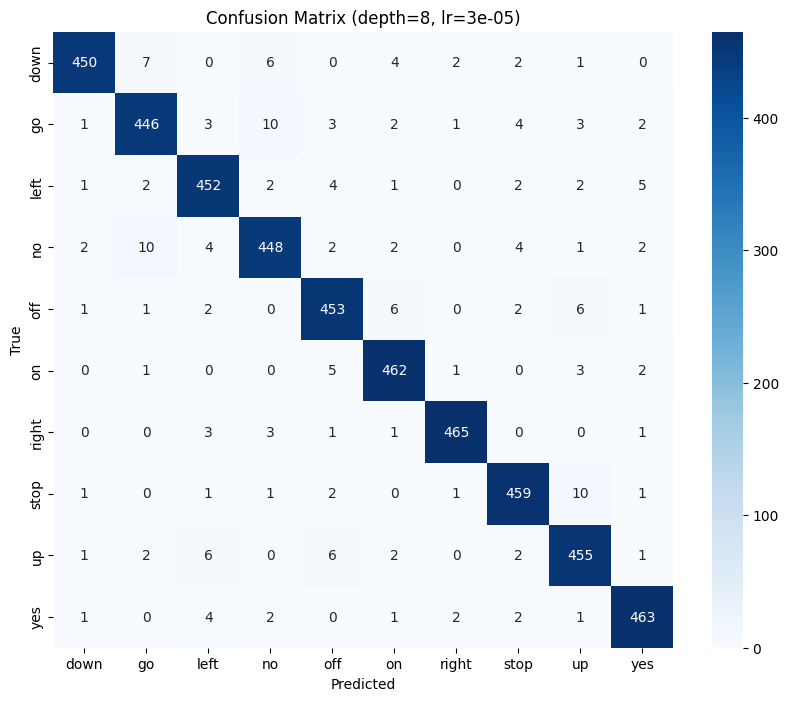


Test Accuracy: 96.05%
F1 Score: 96.06%

Per-class F1 Scores:
  down: 96.77%
  go: 94.49%
  left: 95.56%
  no: 94.61%
  off: 95.57%
  on: 96.75%
  right: 98.31%
  stop: 96.33%
  up: 95.09%
  yes: 97.06%


In [ ]:
main_loop_small(DEPTHS[1], LRS[1])


=== Training with depth=8, lr=0.0001 (ViT-S16) ===


Epoch 1/20: 100%|██████████| 518/518 [02:17<00:00,  3.76it/s]


[Epoch 1] Train Loss: 1.0714 | Train Acc: 63.18% | Val Loss: 0.3463 | Val Acc: 88.45%


Epoch 2/20: 100%|██████████| 518/518 [02:17<00:00,  3.76it/s]


[Epoch 2] Train Loss: 0.2610 | Train Acc: 91.46% | Val Loss: 0.3355 | Val Acc: 89.17%


Epoch 3/20: 100%|██████████| 518/518 [02:17<00:00,  3.76it/s]


[Epoch 3] Train Loss: 0.1668 | Train Acc: 94.47% | Val Loss: 0.1945 | Val Acc: 93.80%


Epoch 4/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 4] Train Loss: 0.1149 | Train Acc: 96.01% | Val Loss: 0.1939 | Val Acc: 94.22%


Epoch 5/20: 100%|██████████| 518/518 [02:17<00:00,  3.75it/s]


[Epoch 5] Train Loss: 0.0903 | Train Acc: 96.86% | Val Loss: 0.2071 | Val Acc: 93.97%


Epoch 6/20: 100%|██████████| 518/518 [02:17<00:00,  3.75it/s]


[Epoch 6] Train Loss: 0.0715 | Train Acc: 97.63% | Val Loss: 0.2572 | Val Acc: 93.38%


Epoch 7/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 7] Train Loss: 0.0572 | Train Acc: 98.15% | Val Loss: 0.2069 | Val Acc: 93.89%


Epoch 8/20: 100%|██████████| 518/518 [02:17<00:00,  3.76it/s]


[Epoch 8] Train Loss: 0.0496 | Train Acc: 98.30% | Val Loss: 0.1929 | Val Acc: 95.11%


Epoch 9/20: 100%|██████████| 518/518 [02:17<00:00,  3.76it/s]


[Epoch 9] Train Loss: 0.0230 | Train Acc: 99.26% | Val Loss: 0.2311 | Val Acc: 94.56%


Epoch 10/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 10] Train Loss: 0.0217 | Train Acc: 99.32% | Val Loss: 0.2239 | Val Acc: 95.03%


Epoch 11/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 11] Train Loss: 0.0208 | Train Acc: 99.26% | Val Loss: 0.2007 | Val Acc: 95.40%


Epoch 12/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 12] Train Loss: 0.0078 | Train Acc: 99.76% | Val Loss: 0.1937 | Val Acc: 95.87%


Epoch 13/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 13] Train Loss: 0.0013 | Train Acc: 99.98% | Val Loss: 0.1727 | Val Acc: 96.46%


Epoch 14/20: 100%|██████████| 518/518 [02:17<00:00,  3.76it/s]


[Epoch 14] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.1713 | Val Acc: 96.63%


Epoch 15/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 15] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1733 | Val Acc: 96.63%


Epoch 16/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 16] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1746 | Val Acc: 96.63%


Epoch 17/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 17] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1754 | Val Acc: 96.59%


Epoch 18/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 18] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1760 | Val Acc: 96.59%


Epoch 19/20: 100%|██████████| 518/518 [02:19<00:00,  3.72it/s]


[Epoch 19] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1762 | Val Acc: 96.59%


Epoch 20/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 20] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1762 | Val Acc: 96.59%


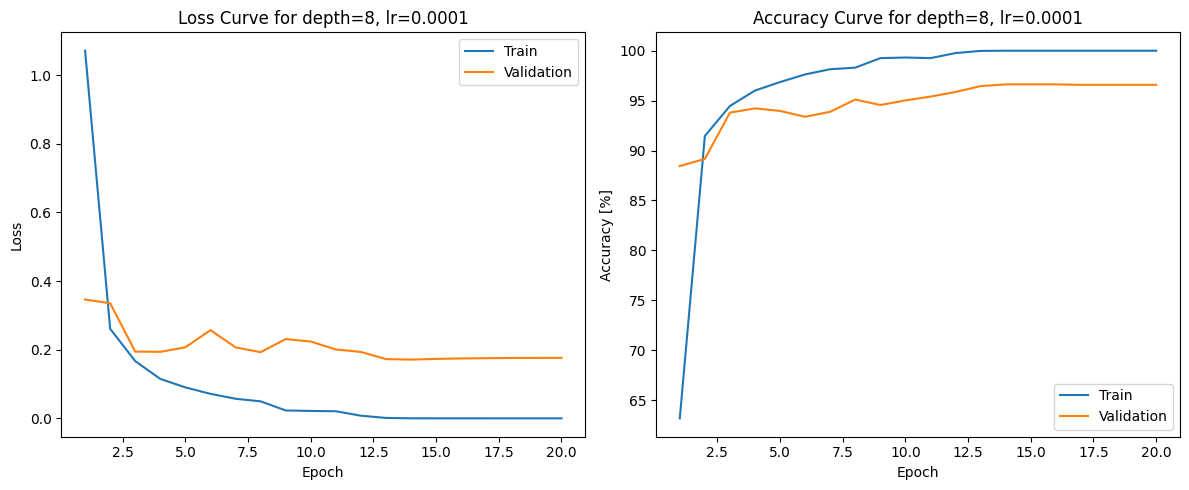

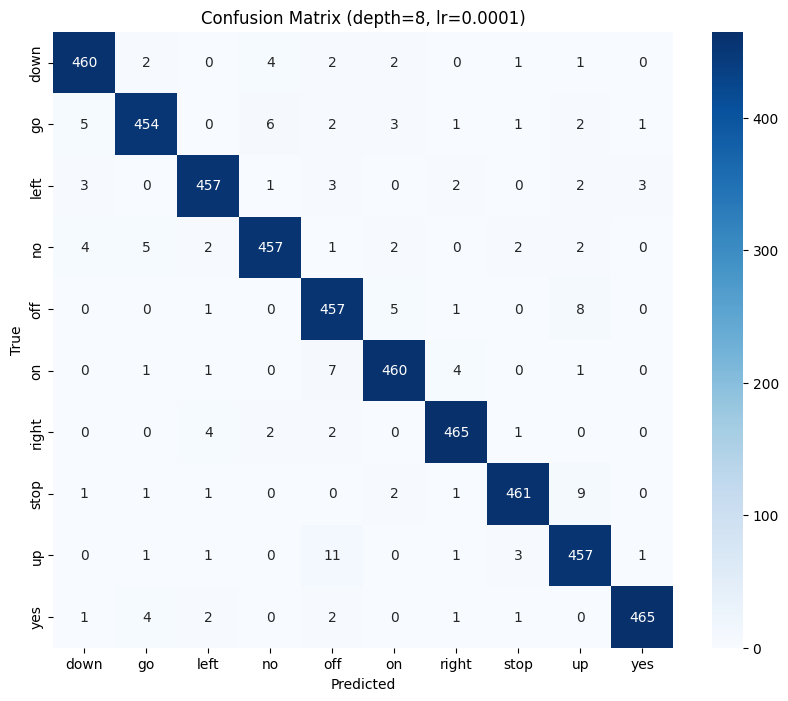


Test Accuracy: 96.90%
F1 Score: 96.90%

Per-class F1 Scores:
  down: 97.25%
  go: 96.29%
  left: 97.23%
  no: 96.72%
  off: 95.31%
  on: 97.05%
  right: 97.89%
  stop: 97.46%
  up: 95.51%
  yes: 98.31%


In [ ]:
main_loop_small(DEPTHS[1], LRS[2])


=== Training with depth=8, lr=0.0003 (ViT-S16) ===


Epoch 1/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 1] Train Loss: 0.8625 | Train Acc: 69.81% | Val Loss: 0.4308 | Val Acc: 85.12%


Epoch 2/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 2] Train Loss: 0.2648 | Train Acc: 91.09% | Val Loss: 0.2309 | Val Acc: 92.37%


Epoch 3/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 3] Train Loss: 0.2112 | Train Acc: 92.85% | Val Loss: 0.1982 | Val Acc: 93.42%


Epoch 4/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 4] Train Loss: 0.1537 | Train Acc: 94.77% | Val Loss: 0.1961 | Val Acc: 94.01%


Epoch 5/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 5] Train Loss: 0.1385 | Train Acc: 95.32% | Val Loss: 0.1773 | Val Acc: 93.68%


Epoch 6/20: 100%|██████████| 518/518 [02:18<00:00,  3.73it/s]


[Epoch 6] Train Loss: 0.1084 | Train Acc: 96.32% | Val Loss: 0.1866 | Val Acc: 94.81%


Epoch 7/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 7] Train Loss: 0.1108 | Train Acc: 96.23% | Val Loss: 0.1762 | Val Acc: 94.77%


Epoch 8/20: 100%|██████████| 518/518 [02:17<00:00,  3.76it/s]


[Epoch 8] Train Loss: 0.0832 | Train Acc: 97.24% | Val Loss: 0.2007 | Val Acc: 94.10%


Epoch 9/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 9] Train Loss: 0.0708 | Train Acc: 97.50% | Val Loss: 0.1979 | Val Acc: 94.56%


Epoch 10/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 10] Train Loss: 0.0653 | Train Acc: 97.71% | Val Loss: 0.1752 | Val Acc: 95.24%


Epoch 11/20: 100%|██████████| 518/518 [02:18<00:00,  3.73it/s]


[Epoch 11] Train Loss: 0.0510 | Train Acc: 98.35% | Val Loss: 0.1682 | Val Acc: 95.32%


Epoch 12/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 12] Train Loss: 0.0312 | Train Acc: 98.90% | Val Loss: 0.1809 | Val Acc: 95.49%


Epoch 13/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 13] Train Loss: 0.0162 | Train Acc: 99.41% | Val Loss: 0.1945 | Val Acc: 96.12%


Epoch 14/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 14] Train Loss: 0.0124 | Train Acc: 99.58% | Val Loss: 0.1938 | Val Acc: 96.08%


Epoch 15/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 15] Train Loss: 0.0035 | Train Acc: 99.90% | Val Loss: 0.2019 | Val Acc: 96.33%


Epoch 16/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 16] Train Loss: 0.0003 | Train Acc: 100.00% | Val Loss: 0.1971 | Val Acc: 96.50%


Epoch 17/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 17] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1980 | Val Acc: 96.50%


Epoch 18/20: 100%|██████████| 518/518 [02:18<00:00,  3.74it/s]


[Epoch 18] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1986 | Val Acc: 96.46%


Epoch 19/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 19] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1989 | Val Acc: 96.46%


Epoch 20/20: 100%|██████████| 518/518 [02:18<00:00,  3.75it/s]


[Epoch 20] Train Loss: 0.0001 | Train Acc: 100.00% | Val Loss: 0.1990 | Val Acc: 96.46%


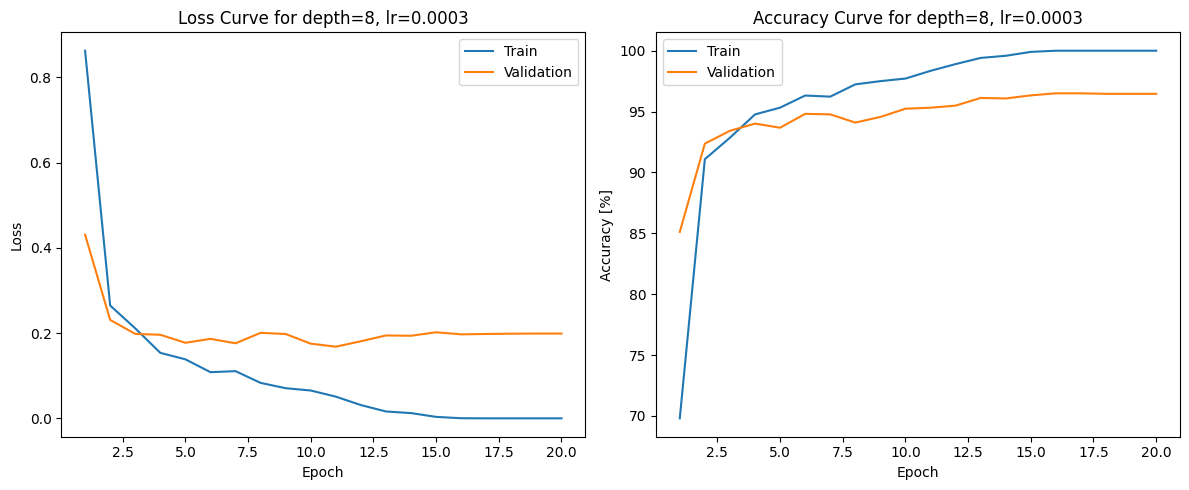

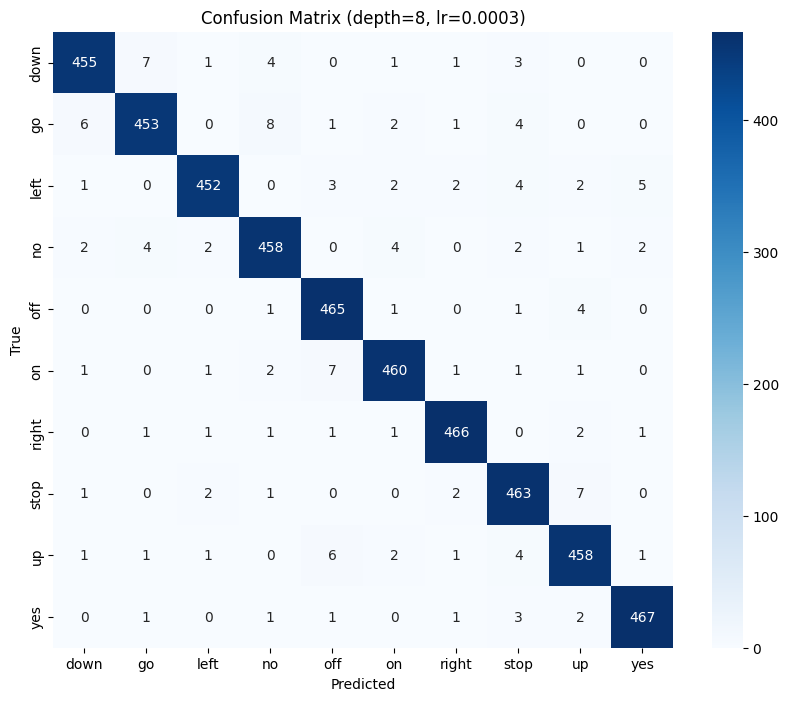


Test Accuracy: 96.98%
F1 Score: 96.98%

Per-class F1 Scores:
  down: 96.91%
  go: 96.18%
  left: 97.10%
  no: 96.32%
  off: 97.28%
  on: 97.15%
  right: 98.21%
  stop: 96.36%
  up: 96.22%
  yes: 98.11%


In [ ]:
main_loop_small(DEPTHS[1], LRS[3])

### We will also test a model with unknown class with the best LR=0.0001 from ViT-B16 model.

In [ ]:
NEW_DATA_ROOT = 'splits/split_10_unknown_balanced/'


def create_model_2(depth):
    model_name = f'vit_base_patch16_224'
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=11,
        depth=depth
    )
    return model.to(DEVICE)

In [ ]:
def create_new_dataloaders():
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # ViT expects 3 channels
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_data = datasets.ImageFolder(
        os.path.join(NEW_DATA_ROOT, 'train'),
        transform=transform
    )
    val_data = datasets.ImageFolder(
        os.path.join(NEW_DATA_ROOT, 'val'),
        transform=transform
    )
    test_data = datasets.ImageFolder(
        os.path.join(NEW_DATA_ROOT, 'test'),
        transform=transform
    )

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    return train_loader, val_loader, test_loader, train_data.classes


=== Training on 11 classes ===


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20: 100%|██████████| 563/563 [10:41<00:00,  1.14s/it]


[Epoch 1] Train Loss: 0.8577 | Train Acc: 71.07% | Val Loss: 0.3396 | Val Acc: 89.56%


Epoch 2/20: 100%|██████████| 563/563 [10:32<00:00,  1.12s/it]


[Epoch 2] Train Loss: 0.2885 | Train Acc: 90.59% | Val Loss: 0.2941 | Val Acc: 90.10%


Epoch 3/20: 100%|██████████| 563/563 [10:32<00:00,  1.12s/it]


[Epoch 3] Train Loss: 0.2013 | Train Acc: 93.52% | Val Loss: 0.1988 | Val Acc: 93.52%


Epoch 4/20: 100%|██████████| 563/563 [10:33<00:00,  1.12s/it]


[Epoch 4] Train Loss: 0.1561 | Train Acc: 94.83% | Val Loss: 0.2019 | Val Acc: 93.28%


Epoch 5/20: 100%|██████████| 563/563 [10:33<00:00,  1.12s/it]


[Epoch 5] Train Loss: 0.1338 | Train Acc: 95.63% | Val Loss: 0.2356 | Val Acc: 92.82%


Epoch 6/20: 100%|██████████| 563/563 [10:31<00:00,  1.12s/it]


[Epoch 6] Train Loss: 0.1043 | Train Acc: 96.53% | Val Loss: 0.1802 | Val Acc: 94.99%


Epoch 7/20: 100%|██████████| 563/563 [10:32<00:00,  1.12s/it]


[Epoch 7] Train Loss: 0.0982 | Train Acc: 96.73% | Val Loss: 0.1827 | Val Acc: 93.98%


Epoch 8/20: 100%|██████████| 563/563 [10:31<00:00,  1.12s/it]


[Epoch 8] Train Loss: 0.0814 | Train Acc: 97.23% | Val Loss: 0.1912 | Val Acc: 94.88%


Epoch 9/20: 100%|██████████| 563/563 [10:32<00:00,  1.12s/it]


[Epoch 9] Train Loss: 0.0658 | Train Acc: 97.83% | Val Loss: 0.1874 | Val Acc: 95.11%


Epoch 10/20: 100%|██████████| 563/563 [10:31<00:00,  1.12s/it]


[Epoch 10] Train Loss: 0.0532 | Train Acc: 98.27% | Val Loss: 0.1586 | Val Acc: 95.30%


Epoch 11/20: 100%|██████████| 563/563 [10:31<00:00,  1.12s/it]


[Epoch 11] Train Loss: 0.0382 | Train Acc: 98.72% | Val Loss: 0.2059 | Val Acc: 95.42%


Epoch 12/20: 100%|██████████| 563/563 [10:31<00:00,  1.12s/it]


[Epoch 12] Train Loss: 0.0272 | Train Acc: 99.08% | Val Loss: 0.2032 | Val Acc: 95.30%


Epoch 13/20: 100%|██████████| 563/563 [10:31<00:00,  1.12s/it]


[Epoch 13] Train Loss: 0.0142 | Train Acc: 99.53% | Val Loss: 0.1914 | Val Acc: 96.04%


Epoch 14/20: 100%|██████████| 563/563 [10:31<00:00,  1.12s/it]


[Epoch 14] Train Loss: 0.0088 | Train Acc: 99.75% | Val Loss: 0.1759 | Val Acc: 95.77%


Epoch 15/20: 100%|██████████| 563/563 [10:32<00:00,  1.12s/it]


[Epoch 15] Train Loss: 0.0049 | Train Acc: 99.83% | Val Loss: 0.1818 | Val Acc: 96.43%


Epoch 16/20: 100%|██████████| 563/563 [10:32<00:00,  1.12s/it]


[Epoch 16] Train Loss: 0.0008 | Train Acc: 99.98% | Val Loss: 0.1903 | Val Acc: 96.31%


Epoch 17/20: 100%|██████████| 563/563 [10:32<00:00,  1.12s/it]


[Epoch 17] Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.1954 | Val Acc: 96.43%


Epoch 18/20: 100%|██████████| 563/563 [10:32<00:00,  1.12s/it]


[Epoch 18] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.1971 | Val Acc: 96.43%


Epoch 19/20: 100%|██████████| 563/563 [10:32<00:00,  1.12s/it]


[Epoch 19] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.1979 | Val Acc: 96.43%


Epoch 20/20: 100%|██████████| 563/563 [10:31<00:00,  1.12s/it]


[Epoch 20] Train Loss: 0.0000 | Train Acc: 100.00% | Val Loss: 0.1980 | Val Acc: 96.43%


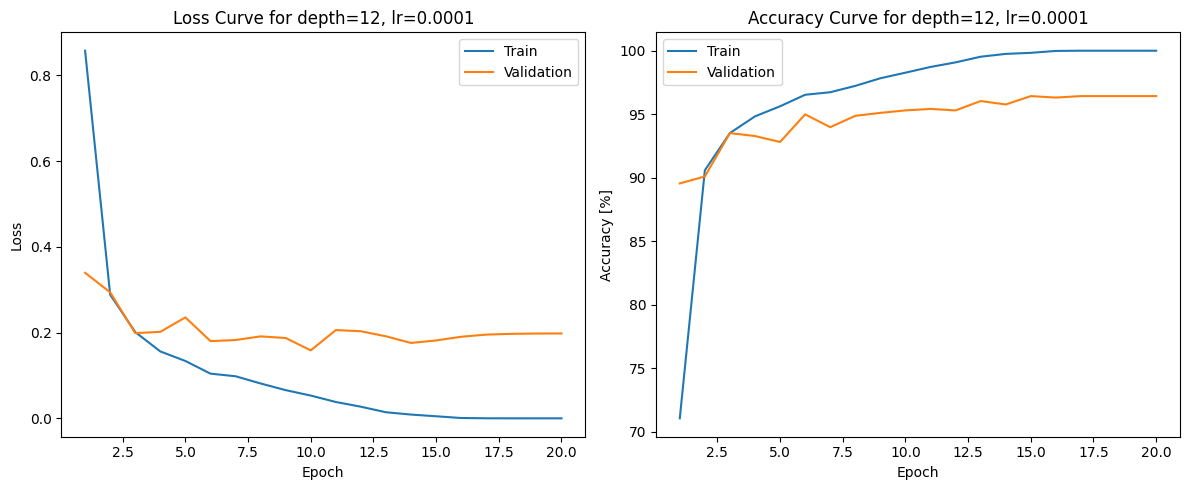

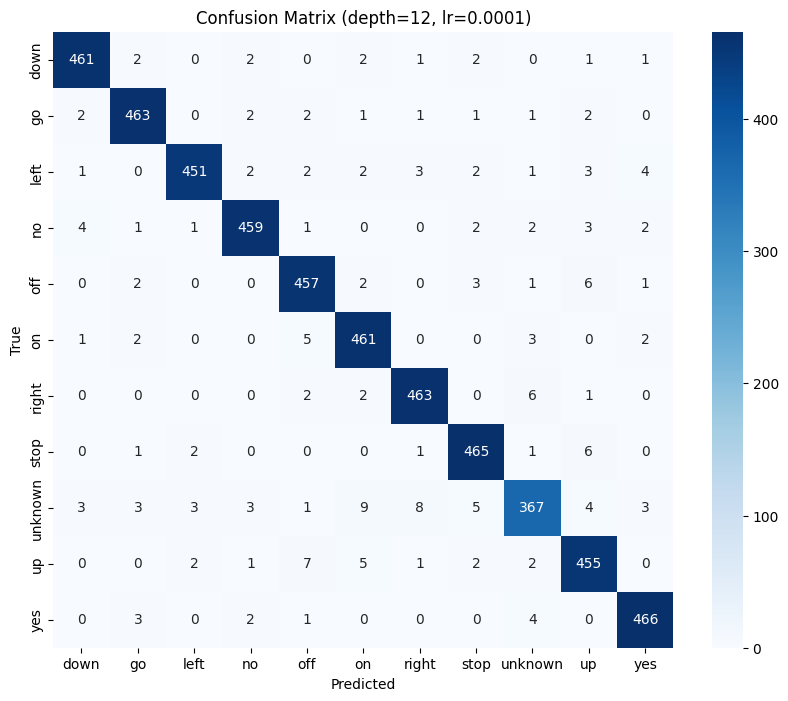


Test Accuracy: 96.48%
F1 Score: 96.48%

Per-class F1 Scores:
  down: 97.67%
  go: 97.27%
  left: 96.99%
  no: 97.04%
  off: 96.21%
  on: 96.24%
  right: 97.27%
  stop: 97.08%
  unknown: 92.10%
  up: 95.19%
  yes: 97.59%


In [ ]:
print(f"\n=== Training on 11 classes ===")
depth = DEPTHS[0]
lr = LRS[2]

# Initialize
train_loader, val_loader, test_loader, classes = create_new_dataloaders()
model = create_model_2(depth)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1*total_steps),
    num_training_steps=total_steps
)

# Training
results = train_model(model, train_loader, val_loader, optimizer, scheduler, criterion, EPOCHS)

# Testing
test_metrics = test_model(model, test_loader, classes)
results['test_metrics'] = test_metrics

# Save results
key = f'depth{depth}_lr{lr}'
all_results[key] = results
torch.save(model.state_dict(), f'{key}_model2.pth')

flat_metrics = {
    'depth': depth,
    'lr': lr,
    'train_losses': str(results['train_loss']),
    'val_losses': str(results['val_loss']),
    'train_accuracies': str(results['train_acc']),
    'val_accuracies': str(results['val_acc']),
    'test_accuracy': test_metrics['accuracy'],
    'test_f1_score': test_metrics['f1_score'],
}

df = pd.DataFrame([flat_metrics])
csv_file = 'training_history_flattened_model2.csv'
if os.path.exists(csv_file):
    existing_df = pd.read_csv(csv_file)
    df = pd.concat([existing_df, df], ignore_index=True)
df.to_csv(csv_file, index=False)

# Plotting
plot_training_curves(results, depth, lr)
print('========')
plot_confusion_matrix(test_metrics['confusion_matrix'], classes, f'Confusion Matrix (depth={depth}, lr={lr})')

# Print metrics
print(f"\nTest Accuracy: {test_metrics['accuracy']:.2f}%")
print(f"F1 Score: {test_metrics['f1_score']:.2f}%")
print("\nPer-class F1 Scores:")
for name, score in zip(test_metrics['class_names'], test_metrics['f1_per_class']):
    print(f"  {name}: {score:.2f}%")